# Bayesian optimization with `skopt`

(based on scikit-optimize documentation https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html)

In [ ]:
# sklearn version fixed to avoid known skopt issue
#!pip install scikit-optimize 
# scikit-learn==0.20.3 

In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from skopt import BayesSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

## Optimising a classifier

In [ ]:
from sklearn.datasets import load_digits
X, y = make_classification(2000, 20, n_informative=10, n_classes=2, random_state=0)
X = X.astype(np.float32)
# X, y = load_digits(10, True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75,
                                                    random_state=0)

dimensions for parameters  [list, shape=(n_dims,)]: List of search space dimensions. Each search dimension can be defined either as

- a (lower_bound, upper_bound) tuple (for Real or Integer dimensions),
- a (lower_bound, upper_bound, prior) tuple (for Real dimensions),
- as a list of categories (for Categorical dimensions), or
- an instance of a Dimension object (Real, Integer or Categorical).

In [ ]:
param_dist = {
    "max_depth": (3, 10,),
    "max_features": (1, 11),
    "min_samples_split": <YOUR CODE>, # from 2 to 10
    "min_samples_leaf": <YOUR CODE>, # from 1 to 10
    "bootstrap": [True, False], # categorical valued parameter
    "criterion": <YOUR CODE> # either "gini" or "entropy"
   }

In [ ]:
param_dist = {
    "max_depth": (3, 10,),
    "max_features": (1, 11),
    "min_samples_split": [2, 5, 10], # from 2 to 10
    "min_samples_leaf": [1, 3, 10], # from 1 to 10
    "bootstrap": [True, False], # categorical valued parameter
    "criterion": ["gini", "entropy"] # either "gini" or "entropy"
   }

In [ ]:
clf = RandomForestClassifier(n_estimators=20)
opt = BayesSearchCV(clf, param_dist, n_iter=60, return_train_score=True, cv=3)

In [ ]:
opt.fit(X_train, y_train);

In [ ]:
print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

In [ ]:
# Utility function to report best scores
import pandas as pd

def report(results, n_top=3):
  res = pd.DataFrame(results)
  res = res.sort_values(by=['mean_test_score'], ascending=False, axis=0)
  res.reset_index(inplace = True, drop=True)
#   a = res[['mean_test_score', 'std_test_score']]

  for candidate in range(0, n_top):
    print("Model with rank: {0}".format(candidate))
    print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
          res['mean_test_score'][candidate],
          res['std_test_score'][candidate]))
    print("Parameters: {0}".format(res['params'][candidate]))
    print("")

In [ ]:
report(opt.cv_results_)

### Analysis

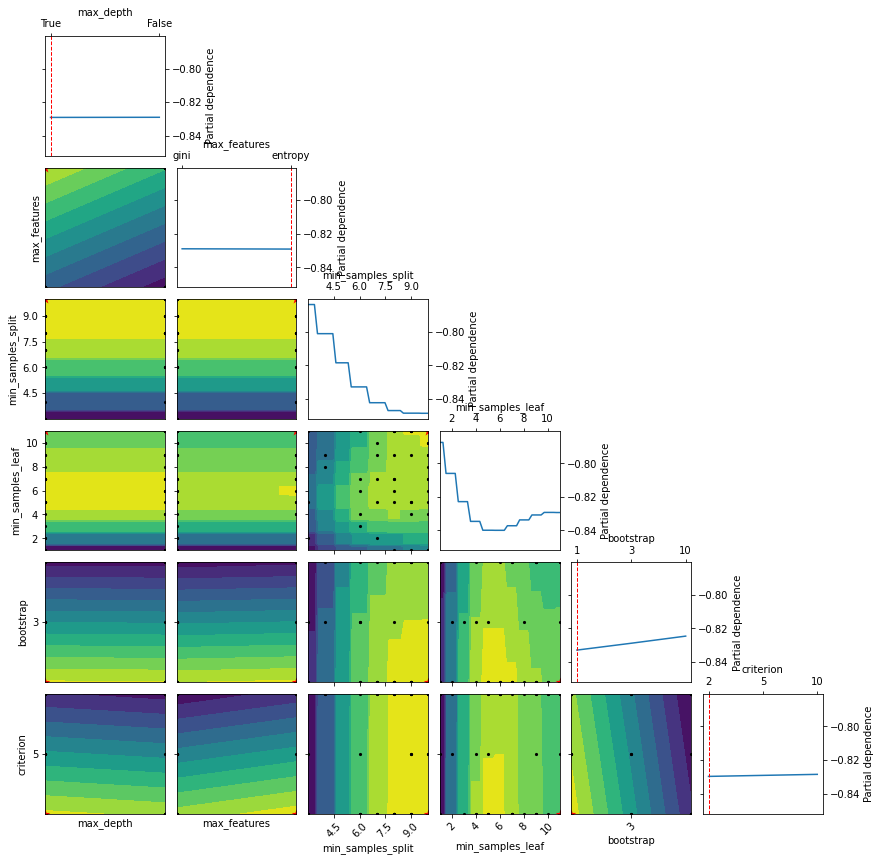

In [18]:
from skopt.plots import plot_objective, plot_histogram

plot_objective(opt.optimizer_results_[0],
                dimensions=list(param_dist.keys()),
                n_minimum_search=int(1e8));

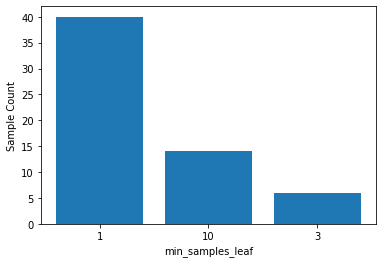

In [25]:
plot_histogram(opt.optimizer_results_[0], "min_samples_leaf" );

## Task
Optimise the neural net from the previous notebook via `BayesSearchCV` 


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
torch.manual_seed(0);

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [ ]:
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    # device='cuda',  # comment this to train with CPU
    optimizer__momentum=0.9,
    verbose=0
)

In [ ]:
params = {
    'lr': [0.05, 0.1],
    'module__num_units': [10, 20, 30], # range from 10 to 50
    'module__dropout': [0.1, 0.3], # range from 0.1 to 0.3
    'optimizer__nesterov': [False, True],
}

In [ ]:
bs = BayesSearchCV(net, params, refit=False, cv=3, scoring='accuracy', 
                  verbose=0, n_jobs=1, n_iter=10, return_train_score=True)

In [ ]:
bs.fit(X, y);

In [ ]:
report(bs.cv_results_)

In [ ]:
### plot objective and histogram of the results